In [1]:
import pandas as pd
import numpy as np

In [20]:
file = '/content/final.csv'
df = pd.read_csv(file)
df = pd.DataFrame(df)
df

,Год,Направление,Уровень безработицы,Уровень инфляции,Вступительный балл,Пол,Образовательные специальные потребности,Дневная/вечерняя форма обучения,Предыдущее образование (оценка),Перемещенный,Возраст при зачислении,Международный статус,ВВП,Количество абитуриентов
0,2022.0,0.0,10.8,1.4,127.3,1,0,1,122.0,1,20,0,1.74,215
1,2023.0,1.0,13.9,-0.3,142.5,1,0,1,160.0,1,19,0,0.79,252
2,2024.0,2.0,10.8,1.4,124.8,1,0,1,122.0,1,19,0,1.74,226
3,2022.0,3.0,9.4,-0.8,119.6,0,0,1,122.0,1,20,0,-3.12,331
4,2023.0,4.0,13.9,-0.3,141.5,0,0,0,100.0,0,45,0,0.79,215
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4419,2022.0,3.0,15.5,2.8,122.2,1,0,1,125.0,0,19,0,-4.06,331
4420,2023.0,3.0,11.1,0.6,119.0,0,0,1,120.0,1,18,1,2.02,331
4421,2024.0,6.0,13.9,-0.3,149.5,0,0,1,154.0,1,30,0,0.79,766
4422,2022.0,13.0,9.4,-0.8,153.8,0,0,1,180.0,1,20,0,-3.12,380


In [25]:
from sklearn.model_selection import train_test_split

X = df[['Пол', 'Возраст при зачислении', 'Дневная/вечерняя форма обучения',
        'Вступительный балл', 'Направление','Предыдущее образование (оценка)']]
y = df.groupby('Направление')['Количество абитуриентов'].mean()
y_full = df['Направление'].map(y.to_dict())

In [26]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.preprocessing import StandardScaler

# Подсчет уникальных направлений
num_directions = len(df['Направление'].unique())
# Масштабирование
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y_full.values.reshape(-1, 1))

# Модель регрессии
def create_regression_model(input_shape):
    model = Sequential([
        keras.Input(shape=(input_shape,)),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='linear')
    ])

    model.compile(
        optimizer='adam',
        loss='mean_squared_error',
        metrics=['mae']
    )
    return model

# Параметры обучения
n_iter = 10
mse_scores = []
mae_scores = []

for i in range(n_iter):
    # Случайное разбиение данных
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y_scaled,
        test_size=0.2,
        random_state=i
    )

    # Создание и обучение модели
    model = create_regression_model(X_train.shape[1])

    history = model.fit(
        X_train, y_train,
        epochs=100,
        validation_split=0.2,
        verbose=0
    )

    # Предсказание
    y_pred = model.predict(X_test)

    # Обратное преобразование шкалы
    y_test_original = scaler_y.inverse_transform(y_test)
    y_pred_original = scaler_y.inverse_transform(y_pred)

    # Расчет метрик
    mse = np.mean((y_test_original - y_pred_original)**2)
    mae = np.mean(np.abs(y_test_original - y_pred_original))

    mse_scores.append(mse)
    mae_scores.append(mae)

    print(f'Итерация {i+1}: MSE = {mse:.2f}, MAE = {mae:.2f}')

# Средние результаты
print(f'Средняя MSE за {n_iter} итераций: {np.mean(mse_scores):.2f}')
print(f'Средний MAE за {n_iter} итераций: {np.mean(mae_scores):.2f}')


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Итерация 1: MSE = 1369.90, MAE = 21.26
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Итерация 2: MSE = 1516.98, MAE = 22.35
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Итерация 3: MSE = 1225.19, MAE = 19.38
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Итерация 4: MSE = 1323.67, MAE = 21.07
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Итерация 5: MSE = 1294.06, MAE = 21.99
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Итерация 6: MSE = 1459.04, MAE = 22.83
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Итерация 7: MSE = 919.77, MAE = 19.99
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Итерация 8: MSE = 1643.87, MAE = 24.26
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Итерация 9: MSE = 990.28, MAE = 19.81
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Итерация 10: MSE = 1280.59, MAE = 23.22
Средняя MSE за 10 итераций: 1302.34
Средний MAE за 10 итераций: 21.62


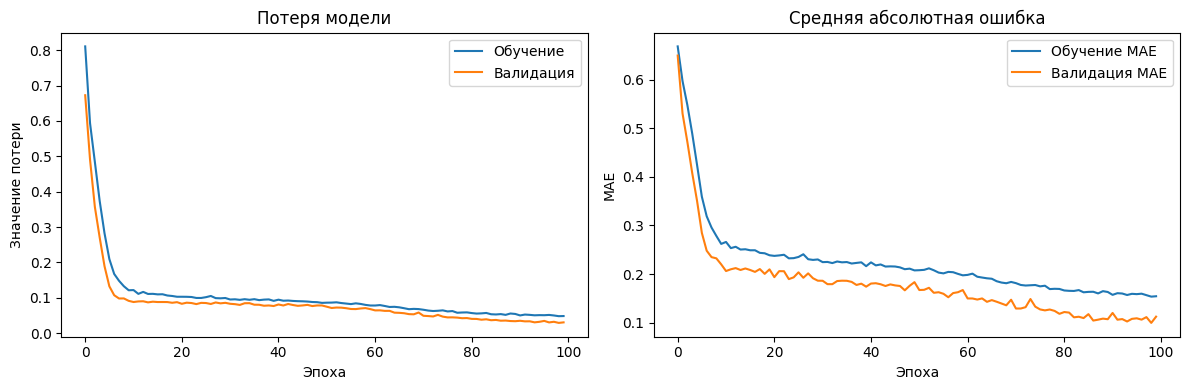

In [27]:
import matplotlib.pyplot as plt

# После обучения модели добавьте:
plt.figure(figsize=(12,4))

# График потери
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Обучение')
plt.plot(history.history['val_loss'], label='Валидация')
plt.title('Потеря модели')
plt.xlabel('Эпоха')
plt.ylabel('Значение потери')
plt.legend()

# График метрики MAE
plt.subplot(1,2,2)
plt.plot(history.history['mae'], label='Обучение MAE')
plt.plot(history.history['val_mae'], label='Валидация MAE')
plt.title('Средняя абсолютная ошибка')
plt.xlabel('Эпоха')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

In [31]:
def predict_directions(model, scaler_X, scaler_y):
    # Уникальные направления
    unique_directions = df['Направление'].unique()

    # Словарь для хранения прогнозов
    predictions = {}

    for direction in unique_directions:
        # Фильтрация данных по направлению
        X_direction = X[X['Направление'] == direction]

        # Масштабирование
        X_direction_scaled = scaler_X.transform(X_direction)

        # Прогноз
        y_pred_scaled = model.predict(X_direction_scaled)

        # Обратное преобразование
        y_pred_original = scaler_y.inverse_transform(y_pred_scaled)

        # Среднее значение для направления
        avg_prediction = int(y_pred_original.mean())

        # Вывод результата
        print(f"Направление {direction}: {avg_prediction} человек")
        predictions[direction] = avg_prediction

    return predictions

# Вызов функции прогноза
predictions = predict_directions(model, scaler_X, scaler_y)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Направление 0.0: 224 человек
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Направление 1.0: 241 человек
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Направление 2.0: 255 человек
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Направление 3.0: 329 человек
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Направление 4.0: 215 человек
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Направление 5.0: 267 человек
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Направление 6.0: 742 человек
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Направление 7.0: 346 человек
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Направление 8.0: 267 человек
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Направление 9.0: 214 человек
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Направление 10.0: 280 человек
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Направление 11.0: 232 человек
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
Направление 12.0: 197 человек
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Направление 13.0: 348 человек
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Направление

In [32]:
y

,Количество абитуриентов
Направление,
0.0,215.0
1.0,252.0
2.0,226.0
3.0,331.0
4.0,215.0
5.0,268.0
6.0,766.0
7.0,355.0
8.0,268.0
